## Import necessary packages

In [1]:
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shapefile
import h5py
import datetime as dt
import pyproj
import gc
from mpl_toolkits.basemap import Basemap

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

## Visualize sea ice concentration data

In [18]:
# Functions to read 25-km resolution AMSR data (Sea ice concentration) from .h5 raw file
def get_AMSR(fileT):

    f1 = h5py.File(fileT, 'r')
    # Latitude & longitude
    lat = f1['HDFEOS/GRIDS/NpPolarGrid25km/lat'][:]
    lon = f1['HDFEOS/GRIDS/NpPolarGrid25km/lon'][:]
    # Sea ice concentration (sic)
    sic = f1['HDFEOS/GRIDS/NpPolarGrid25km/Data Fields/SI_25km_NH_ICECON_DAY'][:]
    
    del f1
    
    return sic, lat, lon

# Calculate Sea ice extent (SIE) from Sea ice concentration (SIC)
# Sea ice extent: area showing SIC > 80 %
def calculate_sie(sic):
    sie = len(sic[(sic >= 80) & (sic <= 100)]) * (25*25) # unit: sq km (grid size: 25 km X 25 km)
    return sie

# Define 11 subregions from lat and lon
def define_regions(lat, lon):
    # subregion: 2D numpy array (same size with lat, lon) showing each region
    subregion = np.zeros(np.shape(lat)) * np.nan
    
    region = {} # region: index of each region in lat, lon arrays
    region['AO'] = np.where(lat>=82) # Central Arctic
    region['BS'] = np.where((lat>=70) & (lat<82) & (lon<-120) & (lon>=-150)) # Beaufort Sea
    region['CS'] = np.where((lat>=67) & (lat<82) & (lon<-150) & (lon>=-180)) # Chukchi Sea
    region['ESS'] = np.where((lat>=70) & (lat<82) & (lon<180) & (lon>=140)) # East-Sibrian Sea
    region['LS'] = np.where((lat>=70) & (lat<82) & (lon<140) & (lon>=100)) # Laptev Sea
    region['KS'] = np.where((lat>=70) & (lat<82) & (lon<100) & (lon>=55)) # Kara Sea
    region['BNS'] = np.where((lat>=67) & (lat<82) & (lon<55) & (lon>=0)) # Barents-Norwegian Sea
    region['GS'] = np.where((lat>=67) & (lat<82) & (lon<0) & (lon>=-40)) # Greenland sea
    region['CA'] = np.where((lat>=67) & (lat<82) & (lon<-70) & (lon>=-120)) # Canadian Archipelago
    region['HB'] = np.where((lat>=52) & (lat<67) & (lon<-70) & (lon>=-95)) # Hudson Bay
    region['BB'] = np.where((lat>=52) & (lat<82) & (lon<-40) & (lon>=-70)) # Baffin Bay
    
    i = 0
    for k in region.keys():
        subregion[region[k]] = i
        i += 1
    
    return subregion, region

## Read AMSR sea ice concentration data

In [640]:
## MAIN =========================================================
## Read all AMSR data
## Output
## - sic_con: 3D numpy array with SIC (row * col * number of days)
## - lat: latitude of each grid point
## - lon: longitude of each grid point

import time
files = sorted(glob.glob("F:\\2021_SIE\\AMSR_25km\\*.he5"))
s0 = time.time()

sic0, lat, lon = get_AMSR(files[0])
subregion, rg_idx = define_regions(lat, lon) # read subregion

first = True
for i in range(0, len(files)):
    
    fileT = files[i]
    t0 = dt.datetime.strptime(fileT[-12:-4], "%Y%m%d")
    
    sic0, lat, lon = get_AMSR(fileT)
    missing = len(sic0[sic0==110])
    # sic = 110: missing data (mostly near north pole)
    # sic = 120: land masking
    # valid sic value: 0-100
    
    # Working with float (includes NaN values)
    # sic = np.zeros(np.shape(lat)) * np.nan
    # sic[sic0 <= 100] = sic0[sic0 <= 100]

    # Working with integer (110 or 120 becomes 0)
    sic = np.copy(sic0)
    sic[sic > 100] = 0
    
    sie = calculate_sie(sic) # calculate SIE from SIC
    df0 = pd.DataFrame({'date': t0, 'year': t0.year, 'month': t0.month, 'SIE': [sie]}) # dataframe of SIE
    df1 = pd.DataFrame({'date': t0, 'year': t0.year, 'month': t0.month, 'SIC': [np.mean(sic[sic>0])]}) # dataframe of SIC
    
    for k in rg_idx.keys(): # calculate SIE for each subregion
        part = sic[rg_idx[k]]
        df0[k] = calculate_sie(part)
        df1[k] = np.mean(part[part>0])
    
    # Number of missing grids >= 300: assume invalid data -> excluded
    if first and missing < 300:
        sic_con = np.copy(sic)
        df_sie = df0
        df_sic = df1
        first = False
    elif missing < 300:
        sic_con = np.dstack((sic_con, sic))
        df_sie = df_sie.append(df0).reset_index(drop = True)
        df_sic = df_sic.append(df1).reset_index(drop = True)
    else:
        print(t0, missing)
        
    del sic0, df0

    if (t0.day == 1) and (t0.month % 2 == 0):
        s1 = time.time()
        print("{0} ... {1}/{2} ({3} sec)".format(t0, i, len(files), round(s1-s0, 2)))
        
print("=== FINISH reading datasets ===")

if len(df_sie) > 3000:
    # Save the resulting numpy array and dataframe
    df_sie.to_csv("F:\\2021_SIE\\result\\SIE_NH.csv") # save SIE 
    df_sic.to_csv("F:\\2021_SIE\\result\\SIC_NH.csv")
    np.save("sic_con", sic_con) # Save numpy array of SIC (.npy)
    np.save("lat", lat) # Save numpy array of latitude (.npy)
    np.save("lon", lon) # Save numpy array of longitude (.npy)

sic_mean = np.mean(sic_con, axis = 2)
# z_mean, z_var, z_skew, z_kurt = get_statistics(sic_mean, r = 2)
print("=== FINISH getting statistical moments ===")

2012-08-01 00:00:00 ... 0/3186 (0.02 sec)
2012-10-01 00:00:00 ... 61/3186 (4.09 sec)
2012-12-01 00:00:00 ... 122/3186 (10.52 sec)
2013-02-01 00:00:00 ... 184/3186 (18.14 sec)
2013-04-01 00:00:00 ... 243/3186 (26.34 sec)
2013-05-14 00:00:00 28048
2013-06-01 00:00:00 ... 301/3186 (35.33 sec)
2013-08-01 00:00:00 ... 362/3186 (45.9 sec)
2013-10-01 00:00:00 ... 423/3186 (57.19 sec)
2013-12-01 00:00:00 ... 484/3186 (69.48 sec)
2014-02-01 00:00:00 ... 546/3186 (82.9 sec)
2014-04-01 00:00:00 ... 605/3186 (96.63 sec)
2014-06-01 00:00:00 ... 666/3186 (111.9 sec)
2014-08-01 00:00:00 ... 727/3186 (128.23 sec)
2014-10-01 00:00:00 ... 788/3186 (145.36 sec)
2014-12-01 00:00:00 ... 849/3186 (162.74 sec)
2015-02-01 00:00:00 ... 911/3186 (181.42 sec)
2015-04-01 00:00:00 ... 970/3186 (200.35 sec)
2015-06-01 00:00:00 ... 1031/3186 (220.8 sec)
2015-08-01 00:00:00 ... 1092/3186 (242.1 sec)
2015-10-01 00:00:00 ... 1153/3186 (264.29 sec)
2015-12-01 00:00:00 ... 1214/3186 (287.39 sec)
2015-12-03 00:00:00 531
2

## Draw maps

In [14]:
# Draw maps of Arctic SIC -----------------------------------------
def draw_map(lat, lon, sic, t0_str):
    fig = plt.figure(figsize = (10, 8))
    
    # Projection: North polar equal area, minimum latitude to display: 52N
    m = Basemap(projection='nplaea',boundinglat=52,lon_0=0,resolution='l')
    m.drawcoastlines() # include coastlines
    m.fillcontinents(color='lightgray',lake_color='white') # fill continent
    
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    
    cmap = cm.get_cmap('Blues_r') # fill color
    m.drawmapboundary(fill_color=cmap(0))
    # draw tissot's indicatrix to show distortion.

    xgrid, ygrid = m(lon, lat)
    sc = plt.scatter(xgrid, ygrid, c = sic, cmap='Blues_r', marker = "s", vmin=0, vmax=100)
    # Draw scatterplot of SIC in the north polar projection
    
    # colorbar
    clb = fig.colorbar(sc, shrink=0.80, pad = 0.02)
    clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 15, va = 'bottom')
    clb.ax.tick_params(labelsize=15)
    plt.title("SIC ({0})".format(t0_str), fontsize = 20)
    plt.savefig('result\\map\\sic_{0}.png'.format(t0_str), bbox_inches = "tight")
    
    plt.close()

In [10]:
## Read saved "sic_con.npy" array 
with open('sic_con.npy', 'rb') as f:
    sic_con = np.load(f)
print("sic_con: ", np.shape(sic_con))

## Read saved "lat.npy" array 
with open('lat.npy', 'rb') as f:
    lat = np.load(f)
print("lat: ", np.shape(lat))

with open('lon.npy', 'rb') as f:
    lon = np.load(f)
print("lon: ", np.shape(lon))

sic_con:  (448, 304, 3175)
lat:  (448, 304)
lon:  (448, 304)


In [15]:
## Map by year

df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    idx = (df_sie['year'] == y)
    sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
    t0_str = str(y)
    draw_map(lat, lon, sic_mean, t0_str)
    print(t0_str)

2013
2014
2015
2016
2017
2018
2019
2020


In [763]:
df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    for m in sorted(df_sie['month'].unique()[:]):
        idx = (df_sie['year'] == y) & (df_sie['month'] == m)
        sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
        t0_str = str(y) + str(m).zfill(2)
        draw_map(lat, lon, sic_mean, t0_str)
        print(t0_str)

201308
201309
201310
201311
201312
201301
201302
201303
201304
201305
201306
201307
201408
201409
201410
201411
201412
201401
201402
201403
201404
201405
201406
201407
201508
201509
201510
201511
201512
201501
201502
201503
201504
201505
201506
201507
201608
201609
201610
201611
201612
201601
201602
201603
201604
201605
201606
201607
201708
201709
201710
201711
201712
201701
201702
201703
201704
201705
201706
201707
201808
201809
201810
201811
201812
201801
201802
201803
201804
201805
201806
201807
201908
201909
201910
201911
201912
201901
201902
201903
201904
201905
201906
201907
202008
202009
202010
202011
202012
202001
202002
202003
202004
202005
202006
202007


In [16]:
import gc
gc.collect()
# Clear memory

134935

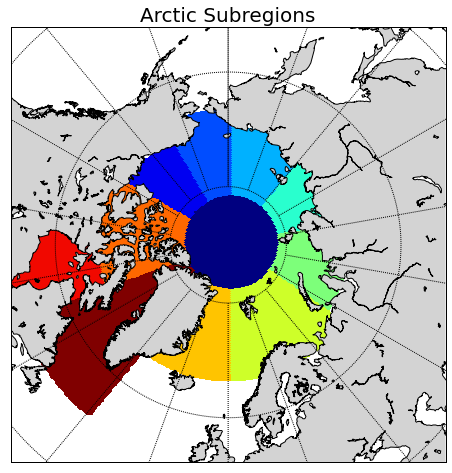

In [19]:
def draw_region(lat, lon, subregion):
    fig = plt.figure(figsize = (10, 8))
    m = Basemap(projection='nplaea',boundinglat=52,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='lightgray',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.drawmapboundary(fill_color='white')
    # draw tissot's indicatrix to show distortion.

    xgrid, ygrid = m(lon, lat)
    plt.scatter(xgrid, ygrid, c = subregion, cmap='jet', marker = "s", vmin=0, vmax=10)
    
    plt.title("Arctic Subregions", fontsize = 20)
    plt.savefig('result\\map\\arctic_subregion.png', bbox_inches = "tight")

subregion, rg_idx = define_regions(lat, lon) # read subregion
draw_region(lat, lon, subregion)

In [20]:
# Show the SIE dataframe
df_sie.head(10)

date  year  month      SIE       AO      BS      CS     ESS      LS  \
0  2012-08-01  2012      8  3784375  2188125  317500  257500  383750  150625   
1  2012-08-02  2012      8  3817500  2180625  332500  230625  438125  155625   
2  2012-08-03  2012      8  3608750  2193125  261250  205625  338125  162500   
3  2012-08-04  2012      8  3522500  2157500  224375  294375  263125  165625   
4  2012-08-05  2012      8  3431875  2135000  330000  114375  271250  164375   
5  2012-08-06  2012      8  3430625  2164375  210000  185000  273750  163125   
6  2012-08-07  2012      8  3426875  2166250  305000  168125  225625  160000   
7  2012-08-08  2012      8  3420625  2187500  285625  166875  229375  172500   
8  2012-08-09  2012      8  3300625  2153125  263125  148125  223750  166875   
9  2012-08-10  2012      8  3218125  2121875  257500  161875  188750  135000   

      KS    BNS      GS      CA     HB    BB  
0   7500  54375   95625  303125  21875     0  
1  14375  41875  120625  285000  16875  1250  
2  19375  35000  113125  262500  16250     0  
3  18125  45000   88125  243125  18750  1875  
4  16875  46875  116875  220000  14375  1875  
5  10625  46250  136250  221250  18750  1250  
6   5625  56250  136250  193125   9375  1250  
7   6250  57500   94375  206875   6875   625  
8   7500  38125   59375  230000   9375  1250  
9   8125  37500   48125  250625   1875  1250

## (1) Temporal analysis

In [21]:
df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)
df_sie['date'] = pd.to_datetime(df_sie['date'])
df_sie = df_sie.loc[(df_sie['date'] < dt.datetime(2021, 1, 1)) &
                    (df_sie['date'] >= dt.datetime(2013, 1, 1)), :].reset_index(drop = True)

df_sie

date  year  month       SIE       AO      BS       CS      ESS  \
0    2013-01-01  2013      1  11578750  2205625  988750  1184375  1225000   
1    2013-01-02  2013      1  11648125  2196875  988750  1183750  1225000   
2    2013-01-03  2013      1  11738125  2192500  988750  1191875  1224375   
3    2013-01-04  2013      1  11808750  2193750  988750  1191875  1224375   
4    2013-01-05  2013      1  11844375  2193750  988750  1185625  1224375   
...         ...   ...    ...       ...      ...     ...      ...      ...   
2903 2020-12-27  2020     12  11336250  2249375  988750  1205625  1224375   
2904 2020-12-28  2020     12  11373125  2247500  988750  1203750  1225000   
2905 2020-12-29  2020     12  11418750  2243750  988750  1200625  1224375   
2906 2020-12-30  2020     12  11445000  2236875  988750  1200000  1225000   
2907 2020-12-31  2020     12  11449375  2237500  988750  1197500  1225000   

          LS      KS     BNS      GS       CA       HB      BB  
0     797500  757500   73125  415000  1131875  1121875  690000  
1     797500  765625   73125  416875  1133125  1122500  680000  
2     797500  751250   73750  426875  1131250  1123125  701875  
3     797500  737500   76250  439375  1128125  1122500  715000  
4     797500  728125   83750  428750  1126875  1123750  746875  
...      ...     ...     ...     ...      ...      ...     ...  
2903  796875  840000  143750  428750  1133125  1056250  543125  
2904  796875  836250  172500  421875  1128125  1066875  554375  
2905  797500  854375  168125  428750  1125625  1086250  587500  
2906  797500  853125  141250  438750  1130625  1105625  600000  
2907  797500  847500  118125  452500  1129375  1116250  611250  

[2908 rows x 15 columns]

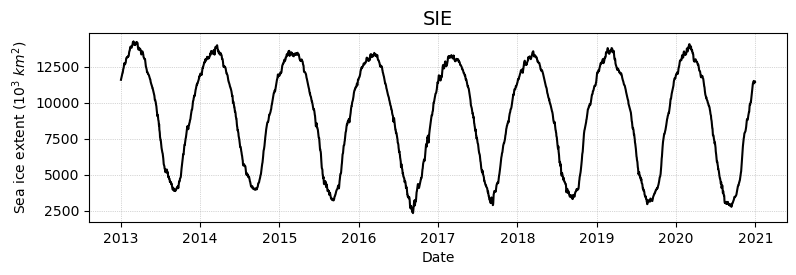

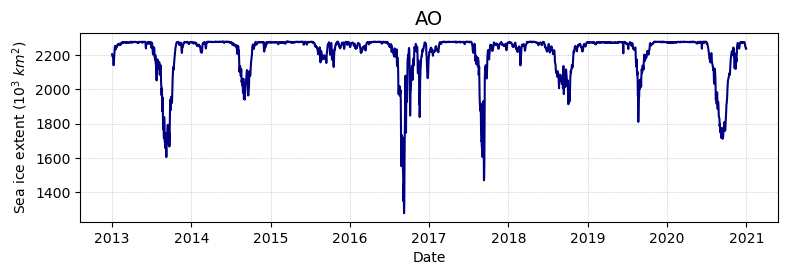

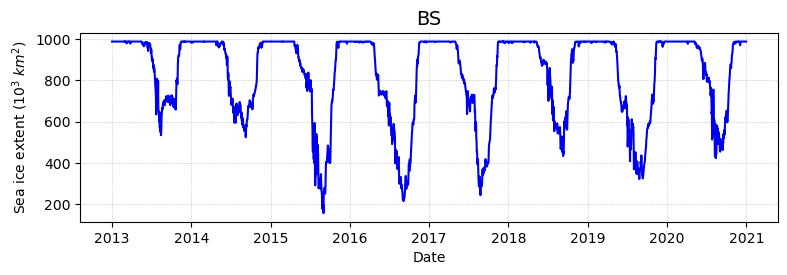

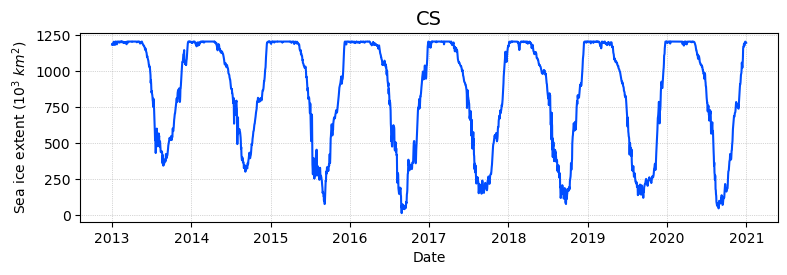

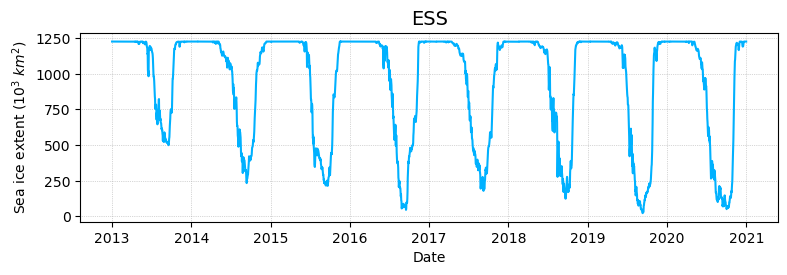

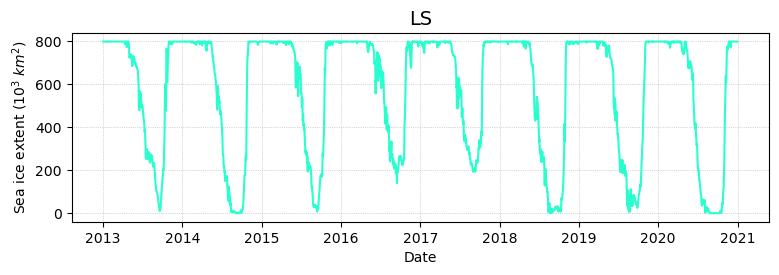

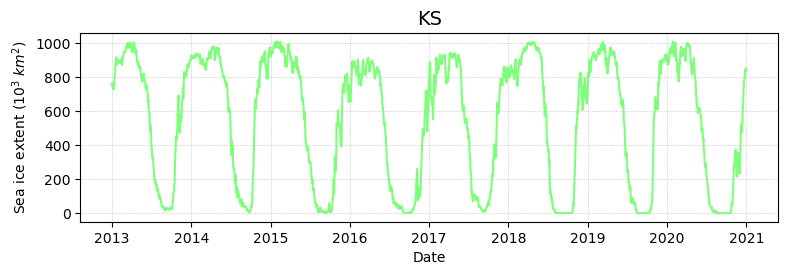

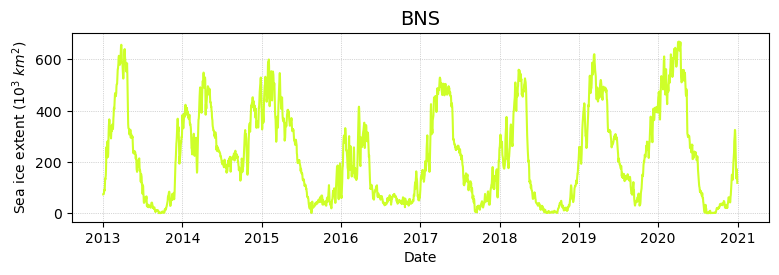

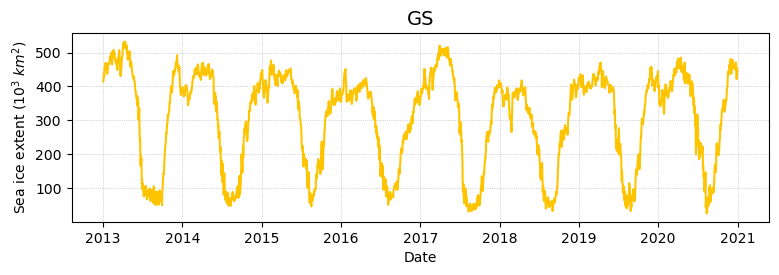

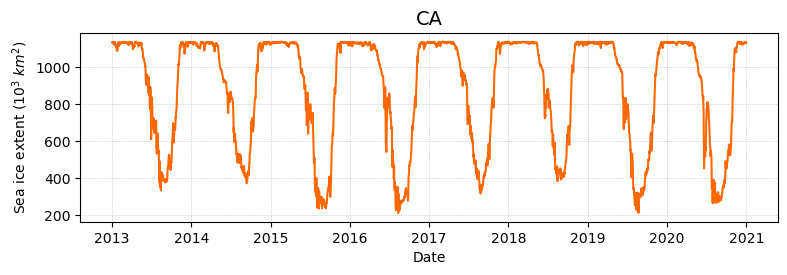

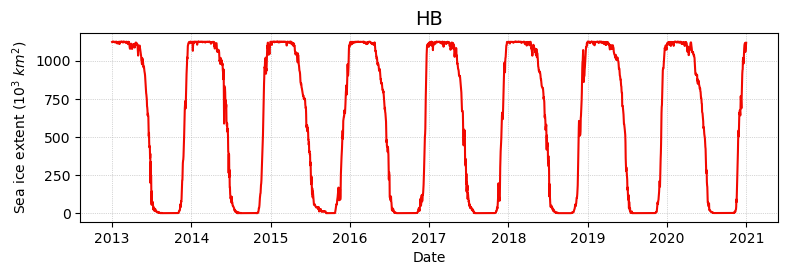

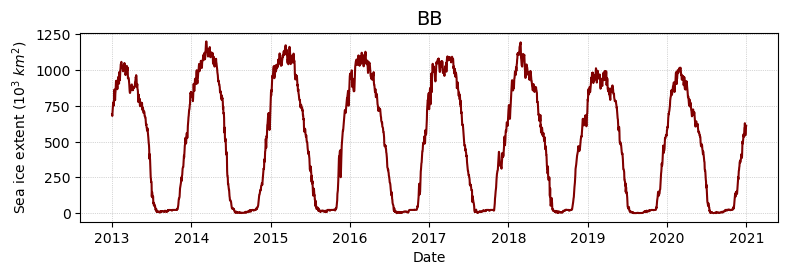

In [22]:
code = 0
for field in df_sie.keys()[3:]:
    plt.figure(figsize = (9,2.5), dpi=100)
    
    if code == 0:
        rgba = "k"
    else:
        cmap = cm.get_cmap('jet')
        rgba = cmap((code-1)/len(df_sie.keys()[5:]))
    
    plt.plot(df_sie['date'], df_sie[field]/1000, color = rgba)
    plt.xlabel("Date")
    plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
    plt.grid(ls = ":", lw = 0.5)
    plt.title(field, fontsize = 14)
    
    plt.savefig("result\\1_temporal\\Daily_SIE_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

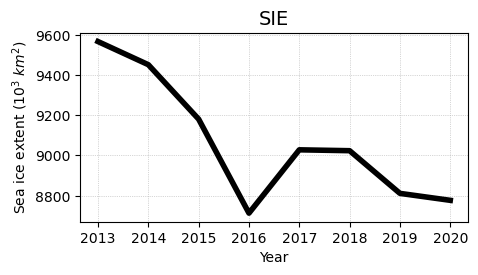

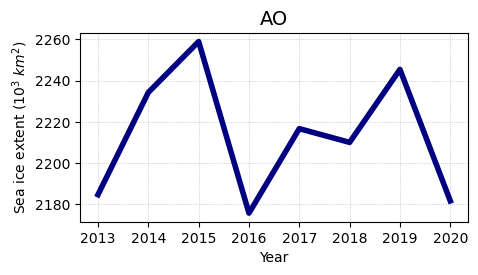

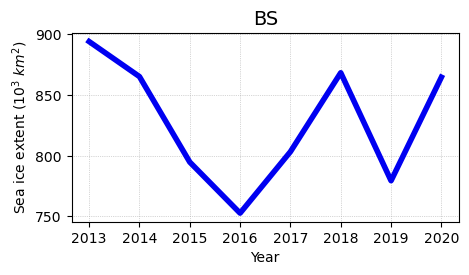

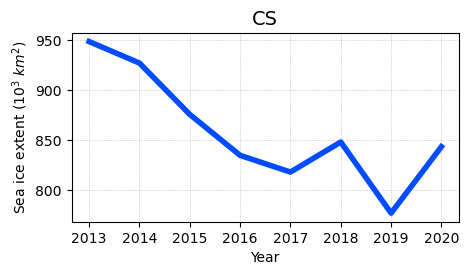

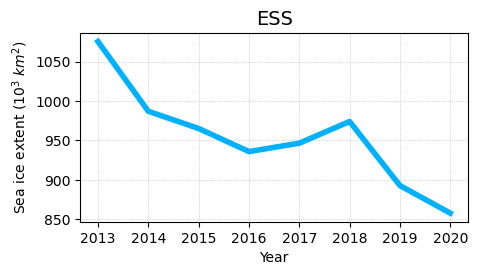

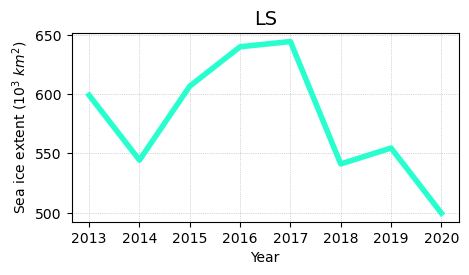

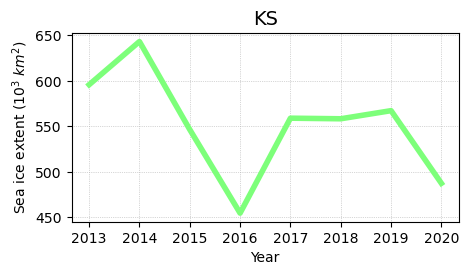

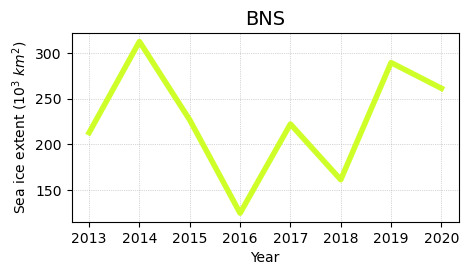

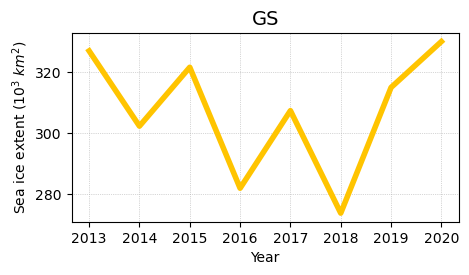

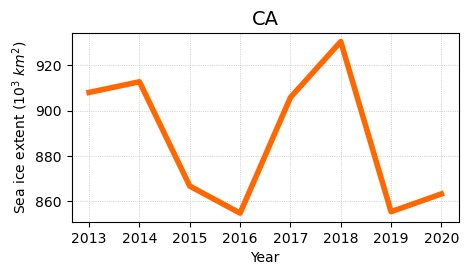

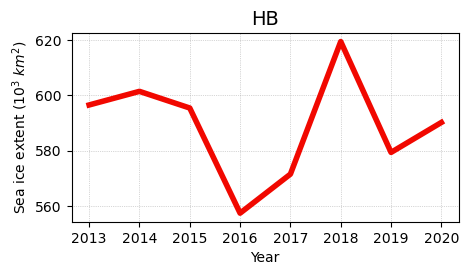

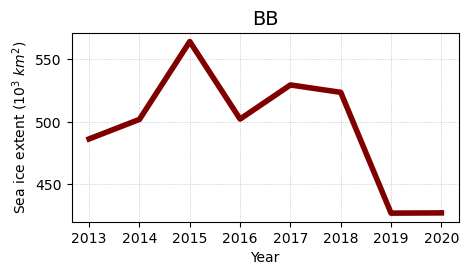

In [23]:
df_year = df_sie.groupby(['year'], as_index=False).mean()
df_year_sd = df_sie.groupby(['year'], as_index=False).std()*0

code = 0
for field in df_year.keys()[2:]:
    plt.figure(figsize = (5,2.5), dpi=100)
    
    if code == 0:
        rgba = "k"
    else:
        cmap = cm.get_cmap('jet')
        rgba = cmap((code-1)/len(df_sie.keys()[5:]))
    
    plt.plot(df_year['year'], df_year[field]/1000, color = rgba, lw = 4)
    plt.fill_between(df_year['year'], df_year[field]/1000 - df_year_sd[field]/1000,
                     df_year[field]/1000 + df_year_sd[field]/1000,
                     alpha = 0.3, linewidth = 0, color = rgba)
    plt.xlabel("Year")
    plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
    plt.grid(ls = ":", lw = 0.5)
    plt.title(field, fontsize = 14)
    
    plt.savefig("result\\1_temporal\\yearly_SIE_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

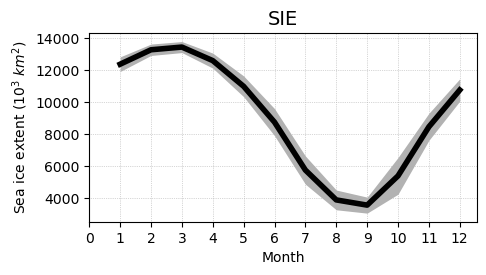

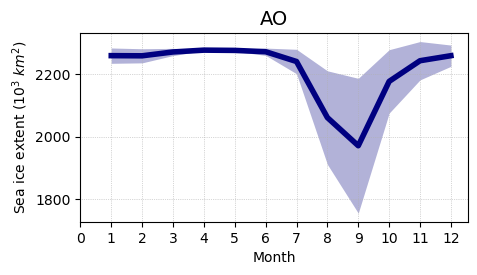

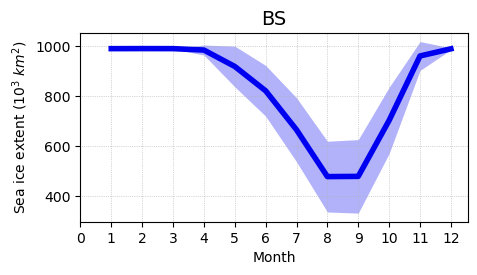

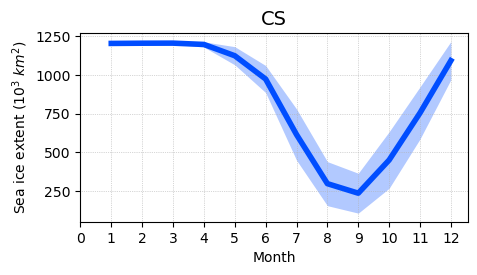

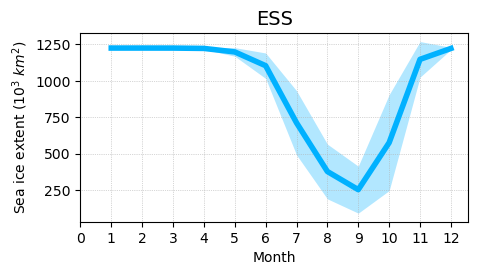

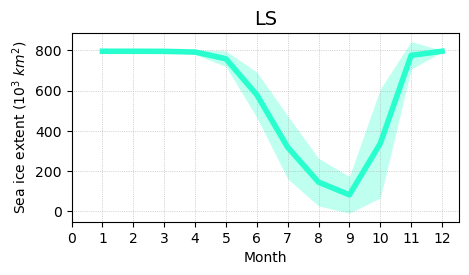

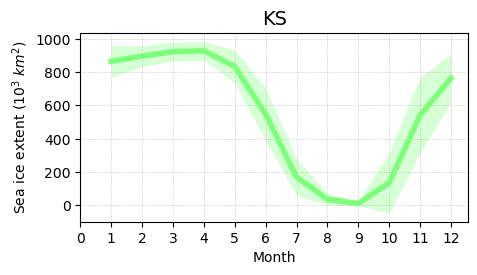

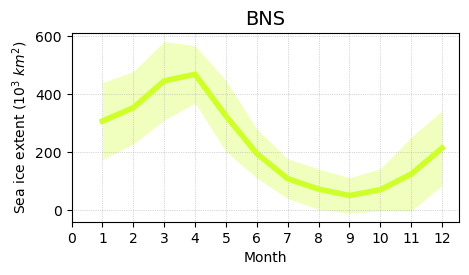

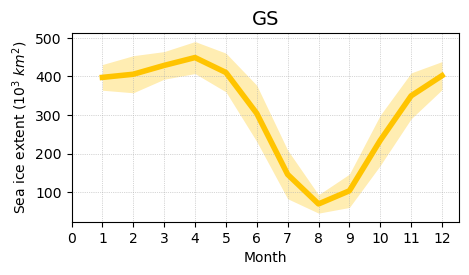

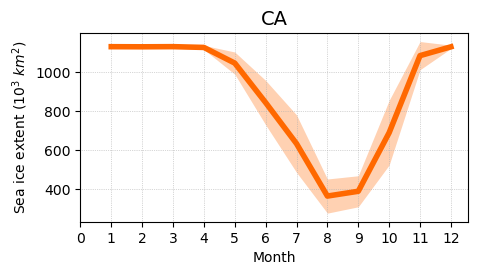

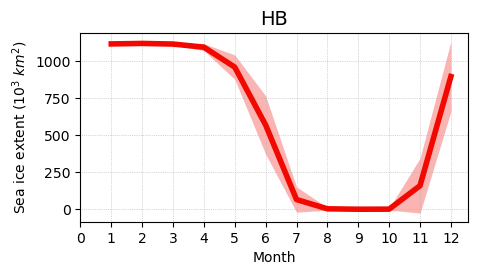

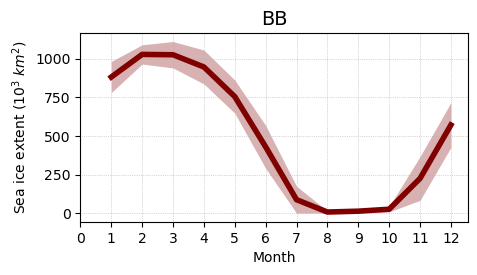

In [24]:
df_month = df_sie.groupby(['month'], as_index=False).mean()
df_month_sd = df_sie.groupby(['month'], as_index=False).std()

code = 0
months = np.arange(0, 13)
for field in df_year.keys()[2:]:
    plt.figure(figsize = (5,2.5), dpi=100)
    
    if code == 0:
        rgba = "k"
    else:
        cmap = cm.get_cmap('jet')
        rgba = cmap((code-1)/len(df_sie.keys()[5:]))
    
    plt.plot(df_month['month'], df_month[field]/1000, color = rgba, lw = 4)
    plt.fill_between(df_month['month'], df_month[field]/1000 - df_month_sd[field]/1000,
                     df_month[field]/1000 + df_month_sd[field]/1000,
                     alpha = 0.3, linewidth = 0, color = rgba)
    plt.xlabel("Month")
    plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
    plt.grid(ls = ":", lw = 0.5)
    plt.title(field, fontsize = 14)
    plt.xticks(months)
    
    plt.savefig("result\\1_temporal\\monthly_SIE_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

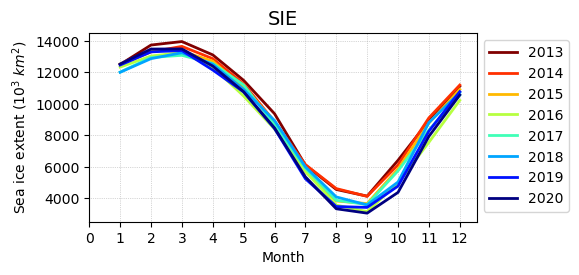

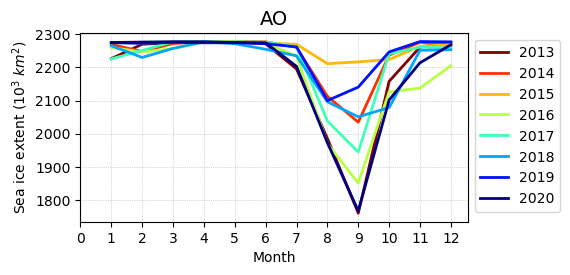

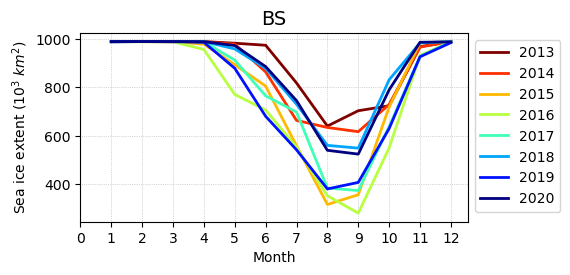

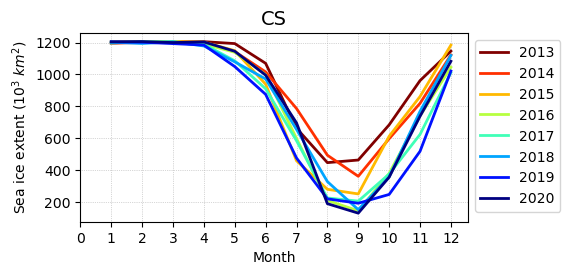

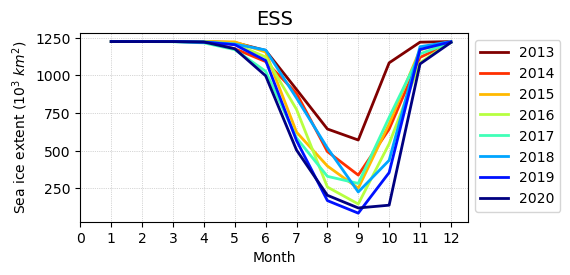

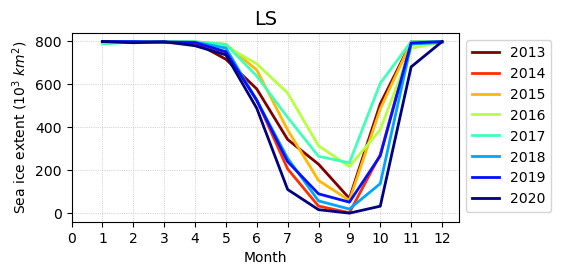

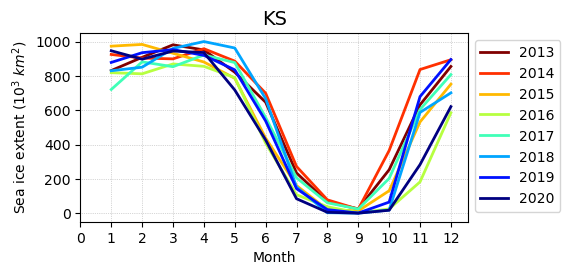

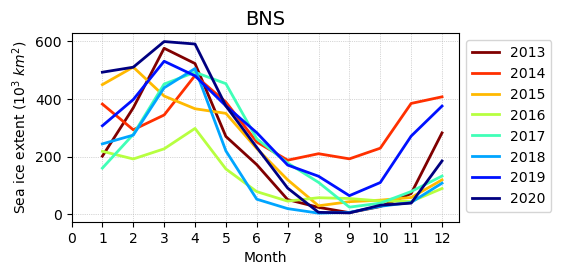

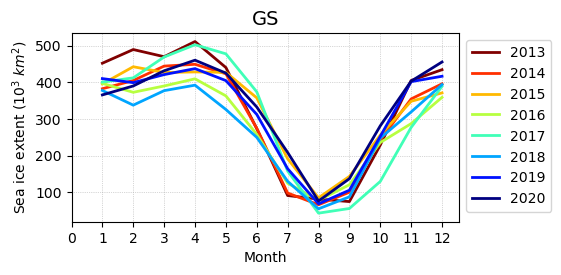

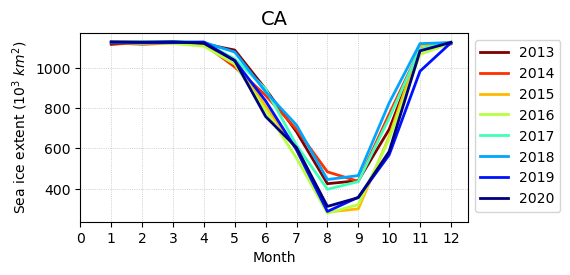

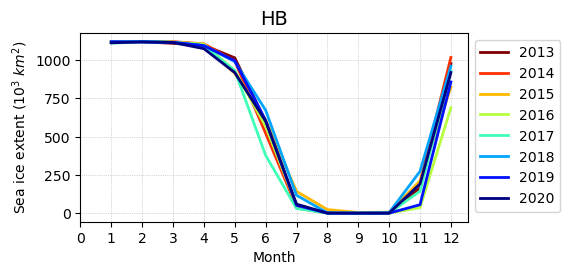

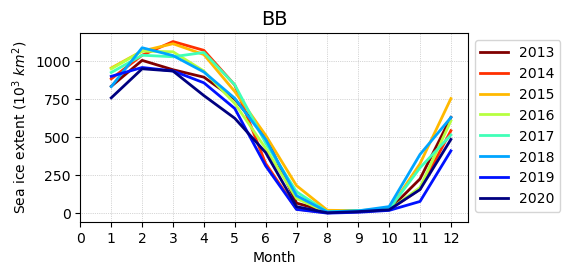

In [25]:
df_month = df_sie.groupby(['month', 'year'], as_index=False).mean()
df_month_sd = df_sie.groupby(['month', 'year'], as_index=False).std()

code = 0
months = np.arange(0, 13)
for field in df_month.keys()[2:]:
    
    plt.figure(figsize = (5,2.5), dpi=100)
    years = pd.unique(df_month['year'])
    
    for y in years:

        cmap = cm.get_cmap('jet')
        rgba = cmap((years.max()-y)/(years.max()-years.min()))
        
        data = df_month.loc[df_month['year'] == y, :]
        plt.plot(data['month'], data[field]/1000, lw = 2, label=y, color = rgba)

        plt.xlabel("Month")
        plt.ylabel("Sea ice extent (${10^3}$ ${km^2}$)")
        plt.grid(ls = ":", lw = 0.5)
        plt.title(field, fontsize = 14)
        plt.xticks(months)
        
    plt.legend(bbox_to_anchor=(1.0, 1))
    plt.savefig("result\\1_temporal\\monthly_SIE_by_year_{0}.png".format(field), bbox_inches = "tight")
    
    code += 1

### * Fourier Transform

In [44]:
from numpy.fft import fft, ifft

In [26]:
## Interpolated null values -------------------------------------------------
df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)
df_sie['date'] = pd.to_datetime(df_sie['date'])
df_sie = df_sie.loc[(df_sie['date'] < dt.datetime(2021, 1, 1)) &
                    (df_sie['date'] >= dt.datetime(2013, 1, 1)), :].reset_index(drop = True)

fields = df_sie.keys()[3:]
dti = pd.date_range(start = "01/01/2013", end = "12/31/2020", freq = "D")

df0 = dti.to_frame(index = False, name = "date")

for i in range(0, len(df0)):
    idx = (df_sie['date'] == df0['date'][i])
    
    if len(idx[idx == True]) > 0:
        for field in fields:
            df0.loc[i, field] = df_sie.loc[idx, field].values[0]
            
df1 = df0.interpolate()
if os.path.exists("result\\SIE_NH_interpolated.csv") != True:
    df1.to_csv("result\\SIE_NH_interpolated.csv")

Processed ...  SIE
Freq:  [0.0, 0.003, 0.005, 0.002, 0.0, 0.001, 0.008, 0.003, 0.001, 0.004]
Period:  [inf, 365.25, 182.625, 487.0, 2922.0, 1461.0, 121.75, 324.667, 730.5, 243.5]
Processed ...  AO
Freq:  [0.0, 0.003, 0.005, 0.008, 0.011, 0.001, 0.003, 0.002, 0.001, 0.014]
Period:  [inf, 365.25, 182.625, 121.75, 91.312, 1461.0, 292.2, 487.0, 730.5, 73.05]
Processed ...  BS
Freq:  [0.0, 0.003, 0.005, 0.0, 0.008, 0.002, 0.001, 0.002, 0.003, 0.005]
Period:  [inf, 365.25, 182.625, 2922.0, 121.75, 487.0, 1461.0, 417.429, 324.667, 208.714]
Processed ...  CS
Freq:  [0.0, 0.003, 0.005, 0.0, 0.002, 0.002, 0.001, 0.007, 0.001, 0.004]
Period:  [inf, 365.25, 182.625, 2922.0, 417.429, 487.0, 1461.0, 146.1, 974.0, 243.5]
Processed ...  ESS
Freq:  [0.0, 0.003, 0.005, 0.008, 0.001, 0.003, 0.002, 0.001, 0.0, 0.002]
Period:  [inf, 365.25, 182.625, 121.75, 1461.0, 292.2, 487.0, 974.0, 2922.0, 584.4]
Processed ...  LS
Freq:  [0.0, 0.003, 0.005, 0.0, 0.008, 0.011, 0.001, 0.002, 0.003, 0.002]
Period:  [inf, 

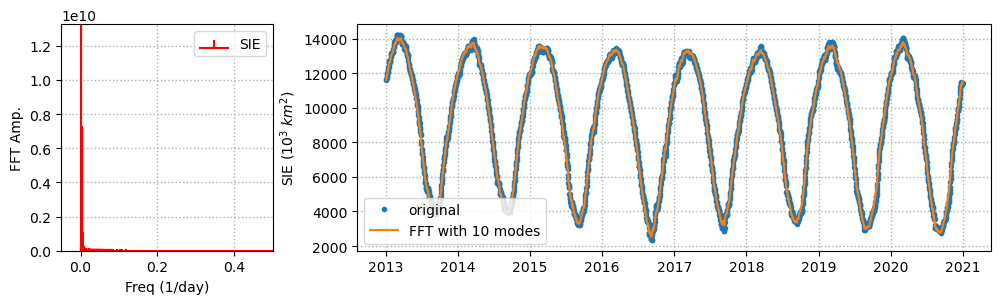

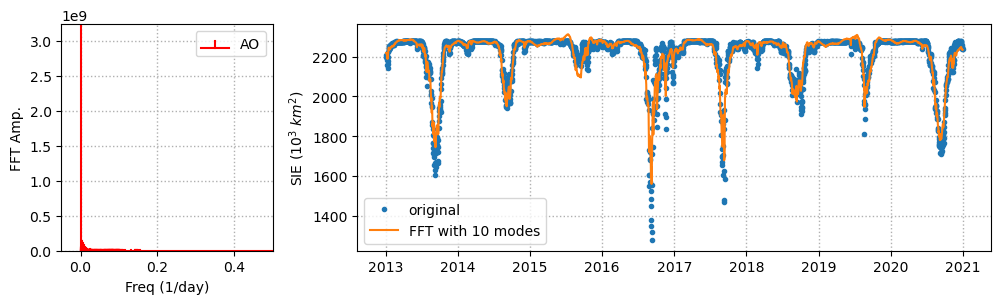

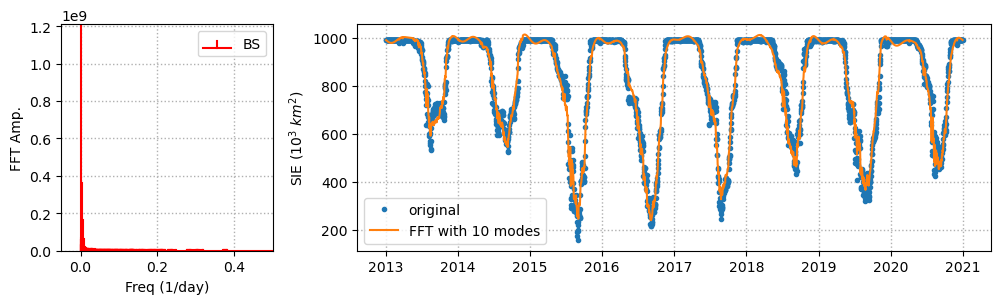

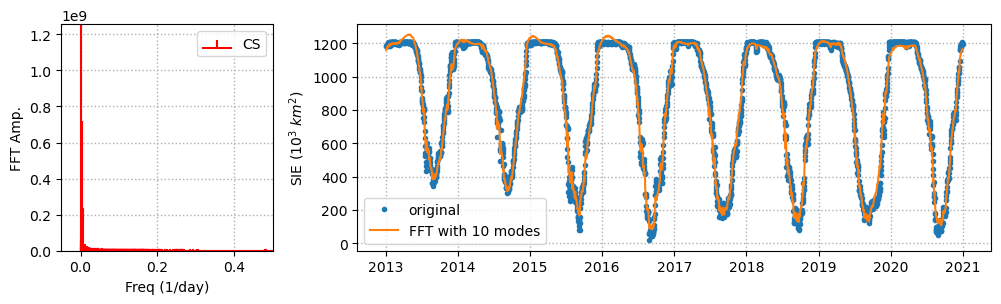

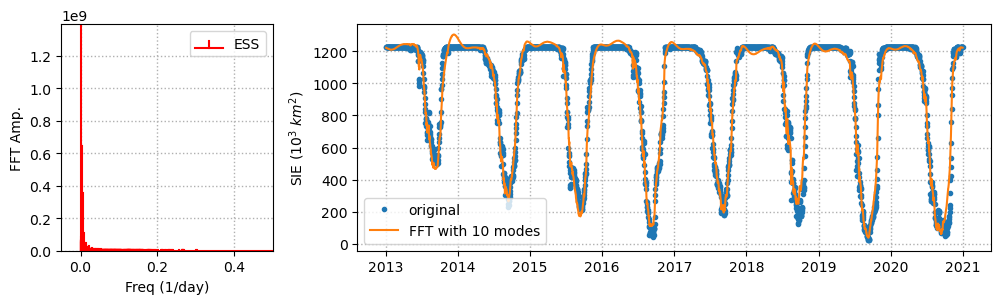

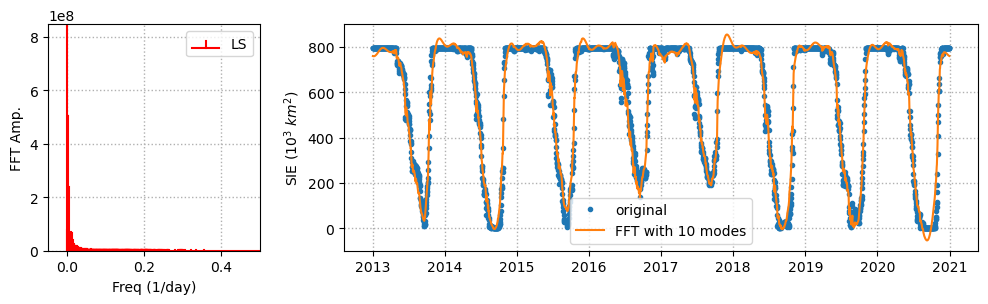

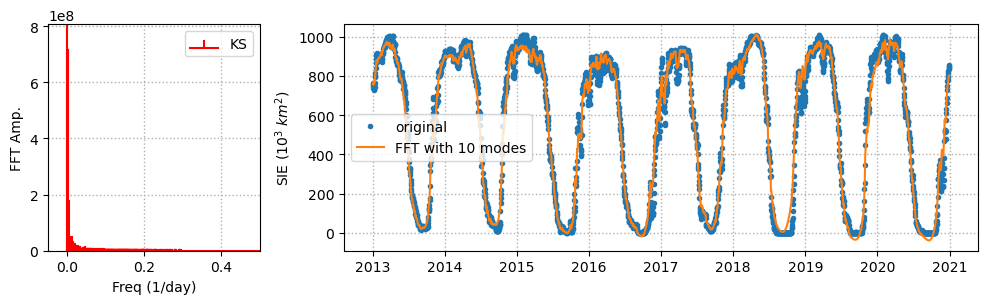

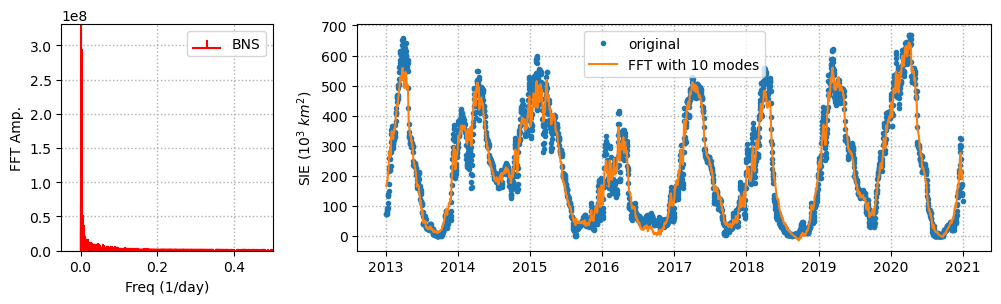

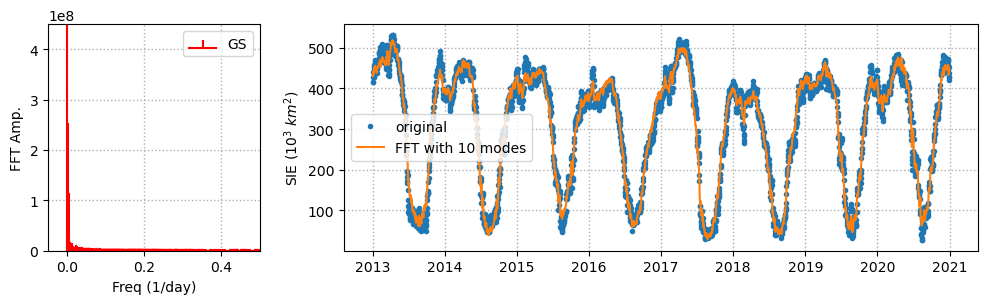

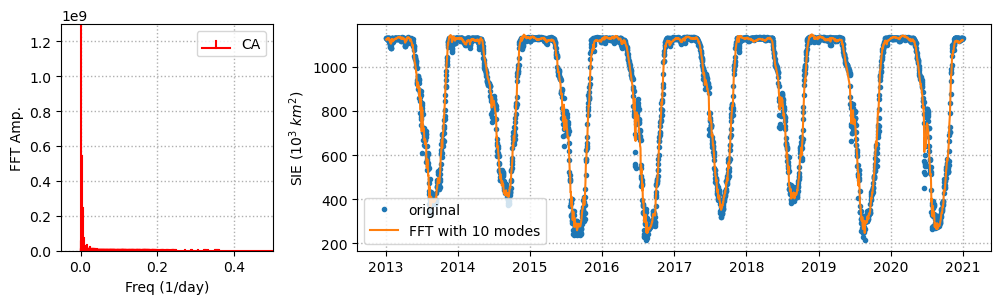

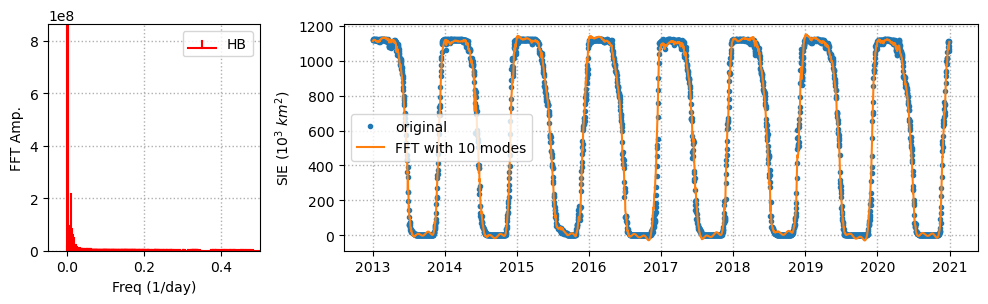

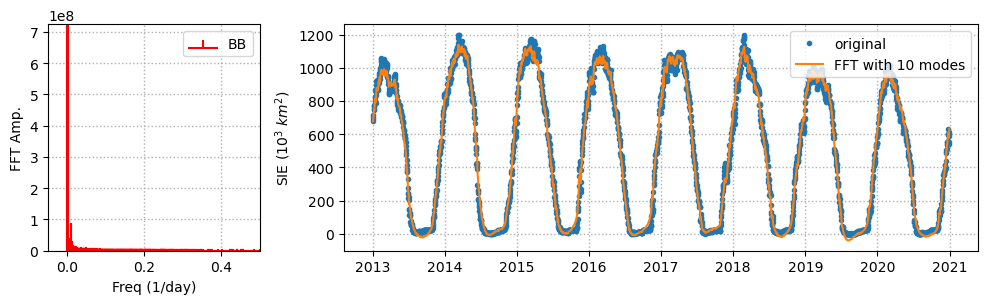

In [45]:
# FFT
df_sample = pd.read_csv("result\\SIE_NH_interpolated.csv", index_col = 0)
df_sample['date'] = pd.to_datetime(df_sample['date'])
top_rank = 10

for field in df_sample.keys()[1:]:
    fig, ax = plt.subplots(1, 2, figsize = (12, 3), dpi = 100, gridspec_kw={'width_ratios': [1,3]})

    X=fft(df_sample[field])
    N=len(X)
    n = np.arange(N)
    
    # original data - about hourly sampling -> sr=24: frequency 1 means 24 hours (one day)
    sr = 1 # sampling ratio
    T= N/sr
    freq=n/T
    
    ax[0].stem(freq, np.abs(X), markerfmt=" ", basefmt="red", linefmt = "red", label = field)
    ax[0].set_ylabel('FFT Amp.')
    ax[0].set_xlabel('Freq (1/day)')
    ax[0].legend()
    # set y-axis limit
    ax[0].set_ylim(0, np.abs(X).max()/2)
    ax[0].grid(linestyle = ":", linewidth = 1)
    ax[0].set_xlim(-0.05, 0.5)    
    
    # plt.savefig("Figures/FFT_freq.png", bbox_inches = "tight")
    
    
    X[np.argsort(np.abs(X[:int(N/2)]))[:-top_rank]] = 0
    Y = ifft(X)
    
    ax[1].plot(df_sample['date'], df_sample[field]/1000, '.', label = "original")
    ax[1].plot(df_sample['date'], Y/1000, label = "FFT with {0} modes".format(top_rank))
    ax[1].set_ylabel("SIE (${10^3}$ ${km^2}$)")
    ax[1].legend()
    ax[1].grid(linestyle = ":", linewidth = 1)
    
    top_freq = [round(f, 3) for f in freq[np.argsort(-np.abs(X[:int(N/2)]))[:top_rank]]]
    top_period = [round(1/f, 3) for f in freq[np.argsort(-np.abs(X[:int(N/2)]))[:top_rank]]]
    
    print("Processed ... ", field)
    print("Freq: ", top_freq)
    print("Period: ", top_period)
    print("=============================================")
    plt.savefig("result\\1_temporal\\FFT_top{0}_{1}.png".format(top_rank, field), bbox_inches = "tight")
    

## (3) Dendrogram

In [27]:
from scipy.cluster import hierarchy
from turbustat.statistics import Dendrogram_Stats
from astrodendro import Dendrogram

In [28]:
# Yearly demdrograms --------------------------------------
df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    t0_str = str(y)

    min_sic = 50 # minimum SIC level to draw dendrogram
    fig, ax =  plt.subplots(1, 2, figsize = (12, 6), dpi = 100)
    idx = (df_sie['year'] == y)
    sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
    d = Dendrogram.compute(sic_mean, min_value=min_sic, min_delta=1, min_npix=40, verbose=False) 
    p = d.plotter()

    # Draw dendrogram
    p.plot_tree(ax[0], color='black')
    p.get_lines()

    ax[0].set_title("Dendrogram_{0}".format(t0_str))

    img = ax[1].imshow(sic_mean, cmap="gray", vmin = 0, vmax=100)
    clb = fig.colorbar(img, ax = ax[1], shrink = 0.7, pad = 0.02)
    clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 12, va = 'bottom')

    cmap = cm.get_cmap('jet')

    k = 0; num = len(d.leaves)

    max_level = 0
    for trk in d.trunk:
        if len(trk.descendants) > 0:
            for des in trk.descendants:
                if des.level >= max_level:
                    max_level = des.level
        if trk.level >= max_level:
            max_level = trk.level

    for trk in d.trunk:
        if len(trk.descendants) > 0:
            for des in trk.descendants:
                rgba = cmap((des.vmin-min_sic)/(100-min_sic))
                p.plot_contour(ax[1], structure=des.idx, lw=0.5, colors=np.array(rgba).reshape(-1,4))
                ax[0].axhline(des.vmin, color = rgba, alpha = 0.3, label = des.level)
        rgba = cmap((trk.vmin-min_sic)/(100-min_sic))
        p.plot_contour(ax[1], structure=trk.idx, lw=0.5, colors=np.array(rgba).reshape(-1,4))
        ax[0].axhline(trk.vmin, color = rgba, alpha = 0.3, label = trk.level)

    ax[1].set_title("Contour_{0}".format(t0_str))

    plt.savefig("result\\2_dendrogram\\dendro_{0}.png".format(t0_str), bbox_inches = "tight")
    plt.close()
        
    print(y)

2013
2014
2015
2016
2017
2018
2019
2020


In [1021]:
# Monthly demdrograms --------------------------------------
df_sie = pd.read_csv("F:\\2021_SIE\\result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    for m in sorted(df_sie['month'].unique()[:]):
        t0_str = str(y) + str(m).zfill(2)
        
        min_sic = 50 # minimum SIC level to draw dendrogram
        fig, ax =  plt.subplots(1, 2, figsize = (12, 6), dpi = 100)
        idx = (df_sie['year'] == y) & (df_sie['month'] == m)
        sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
        d = Dendrogram.compute(sic_mean, min_value=min_sic, min_delta=1, min_npix=40, verbose=False) 
        p = d.plotter()
        
        # Draw dendrogram
        p.plot_tree(ax[0], color='black')
        p.get_lines()
        
        ax[0].set_title("Dendrogram_{0}".format(t0_str))
        
        img = ax[1].imshow(sic_mean, cmap="gray", vmin = 0, vmax=100)
        clb = fig.colorbar(img, ax = ax[1], shrink = 0.7, pad = 0.02)
        clb.set_label('Sea ice conc. (%)', rotation = 270, fontsize = 12, va = 'bottom')
        
        cmap = cm.get_cmap('jet')
        
        k = 0; num = len(d.leaves)
        
        max_level = 0
        for trk in d.trunk:
            if len(trk.descendants) > 0:
                for des in trk.descendants:
                    if des.level >= max_level:
                        max_level = des.level
            if trk.level >= max_level:
                max_level = trk.level
        
        for trk in d.trunk:
            if len(trk.descendants) > 0:
                for des in trk.descendants:
                    rgba = cmap((des.vmin-min_sic)/(100-min_sic))
                    p.plot_contour(ax[1], structure=des.idx, lw=0.5, colors=np.array(rgba).reshape(-1,4))
                    ax[0].axhline(des.vmin, color = rgba, alpha = 0.3, label = des.level)
            rgba = cmap((trk.vmin-min_sic)/(100-min_sic))
            p.plot_contour(ax[1], structure=trk.idx, lw=0.5, colors=np.array(rgba).reshape(-1,4))
            ax[0].axhline(trk.vmin, color = rgba, alpha = 0.3, label = trk.level)
        
        ax[1].set_title("Contour_{0}".format(t0_str))
        
        plt.savefig("result\\2_dendrogram\\dendro_{0}.png".format(t0_str), bbox_inches = "tight")
        plt.close()
        
    print(y)

2013
2014
2015
2016
2017
2018
2019
2020


## (4) Get statistical moments (skewness & kurtosis)

In [33]:
# Get statistical moments (skewness & kurtosis) -----------------
from scipy.stats import kurtosis, skew

def get_statistics(z, r = 5):
    h,w = np.shape(z)
    z_mean = np.zeros((h, w)) # Mean
    z_var = np.zeros((h, w)) # Variations
    z_skew = np.zeros((h, w)) # skewness
    z_kurt = np.zeros((h, w)) # kurtosis
    
    for i in range(0, h):
        for j in range(0, w):
            part = z[max(0, i-r):min(h, i+r), max(0, j-r):min(w, j+r)]
            part = part[part > 0] # only calculate for valid part (exclude 0 SIC and land area)
            z_mean[i,j] = np.mean(part)
            z_var[i,j] = np.var(part)
            z_skew[i,j] = skew(part.flatten())
            z_kurt[i,j] = kurtosis(part.flatten())
    
    return z_mean, z_var, z_skew, z_kurt

2013
2014
2015
2016
2017
2018
2019
2020


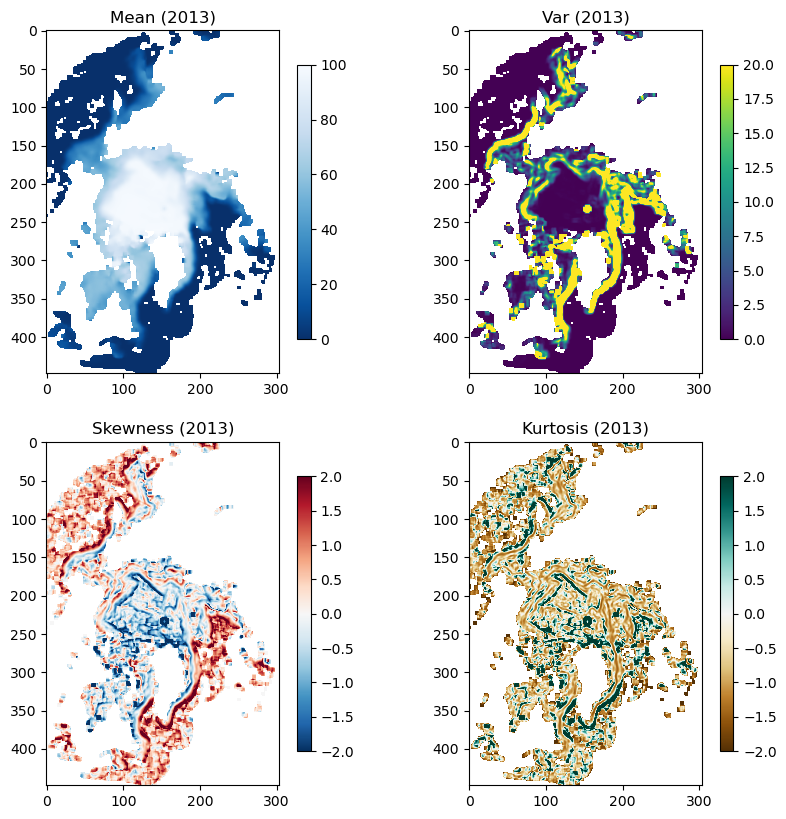

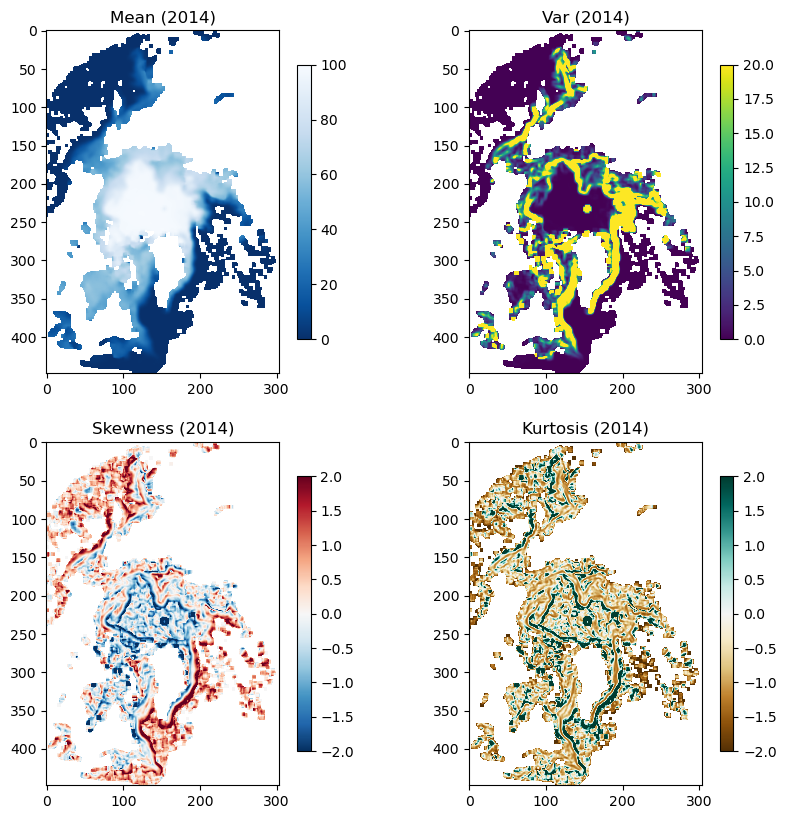

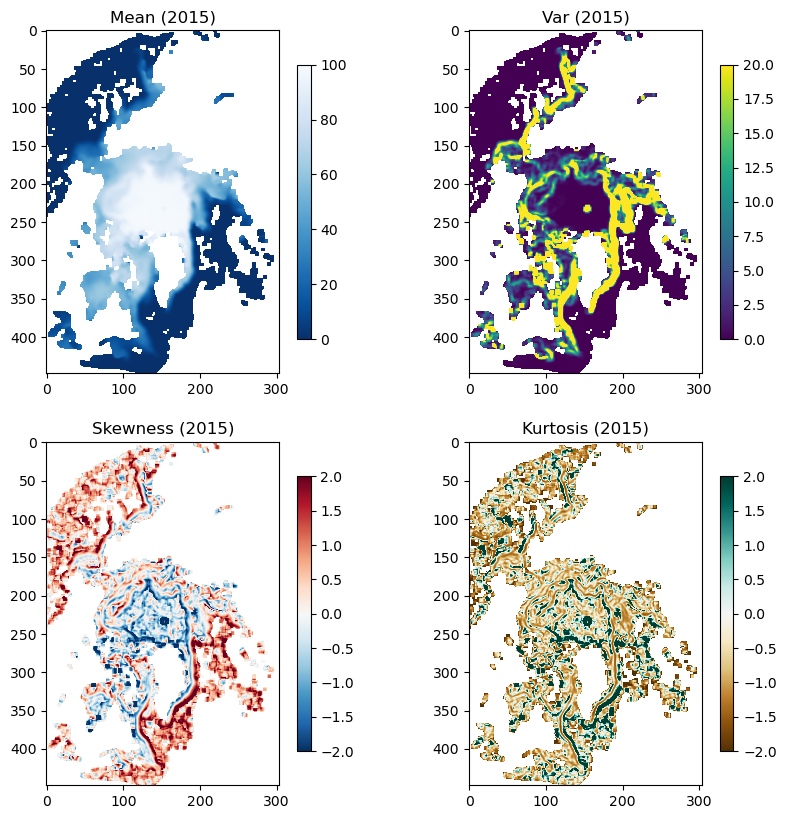

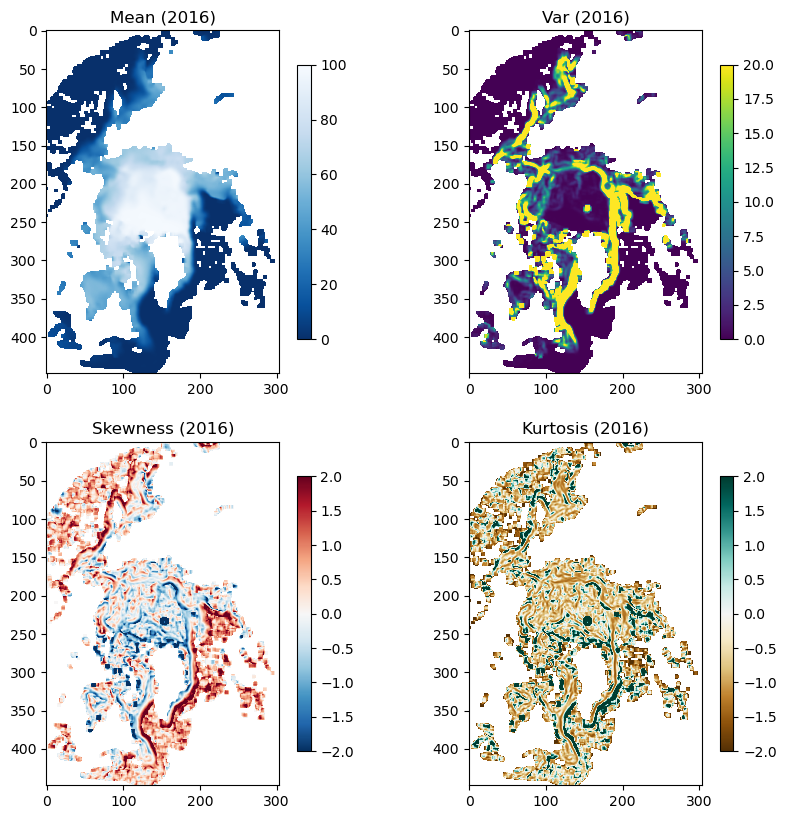

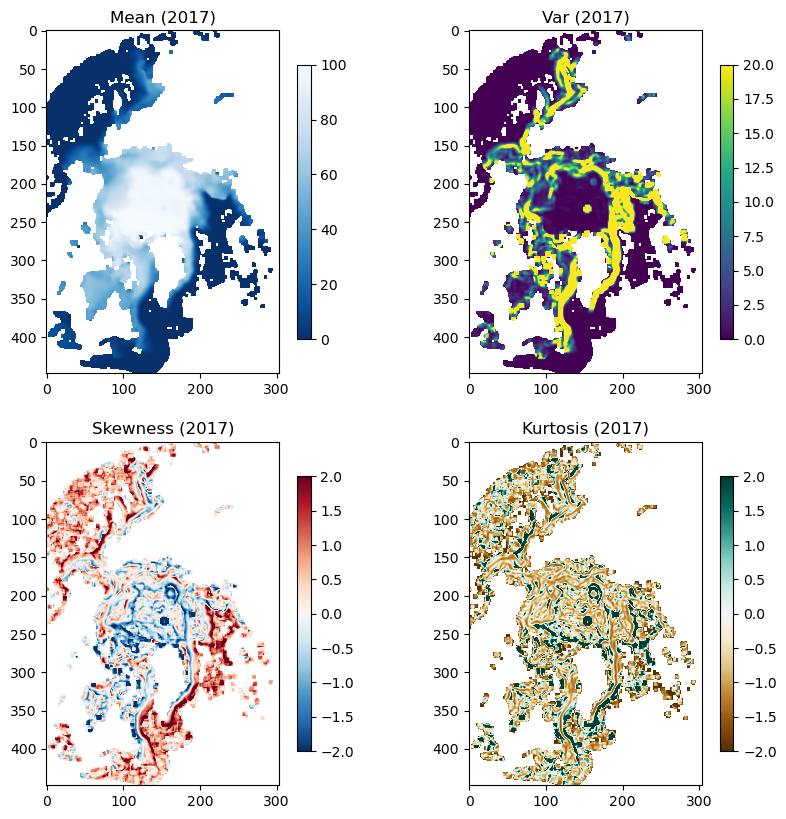

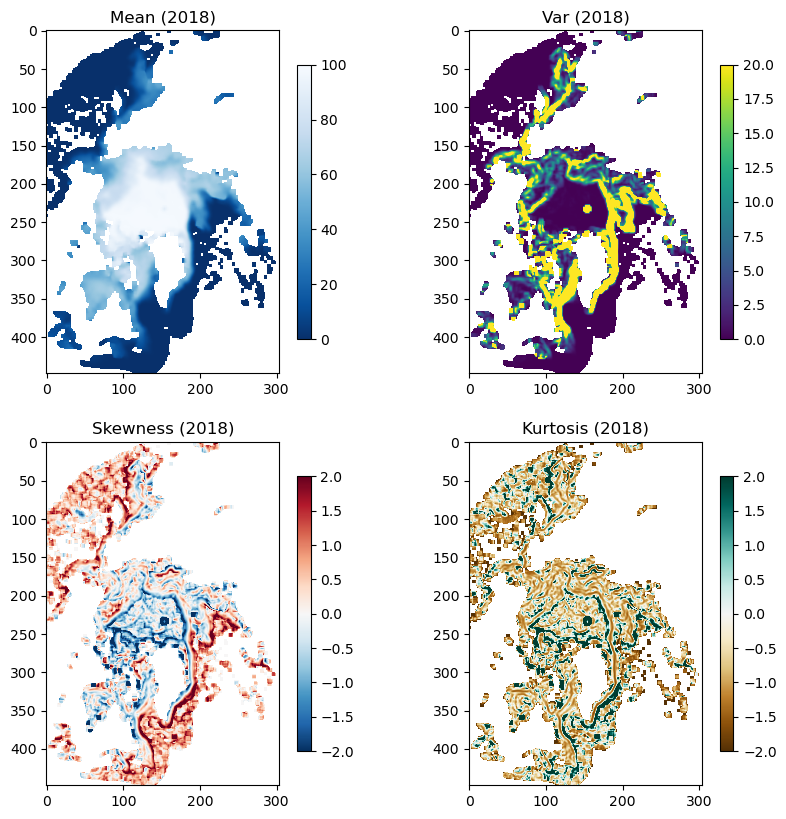

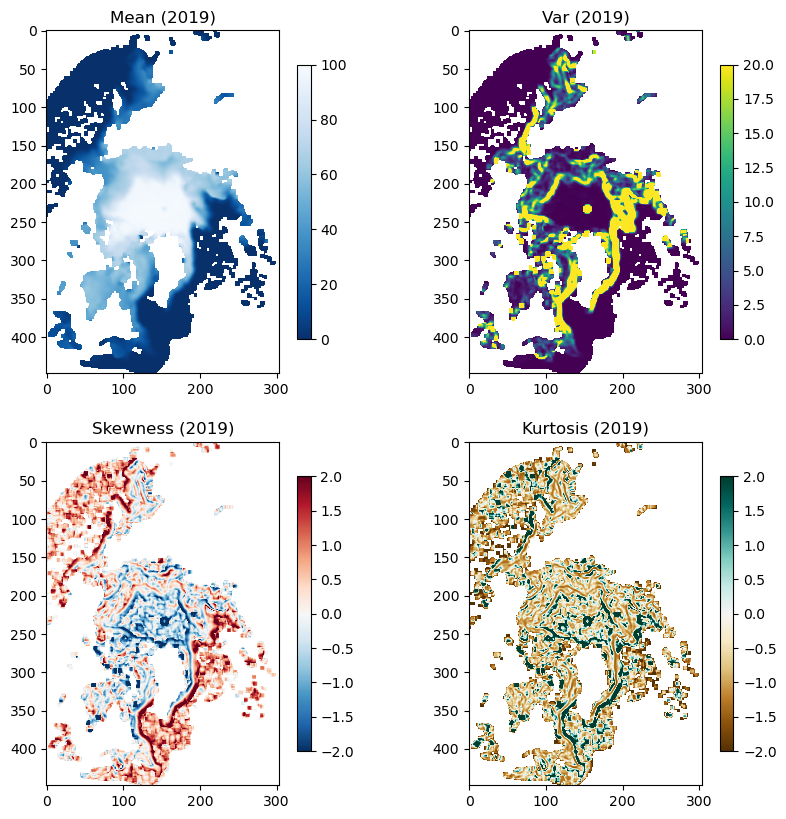

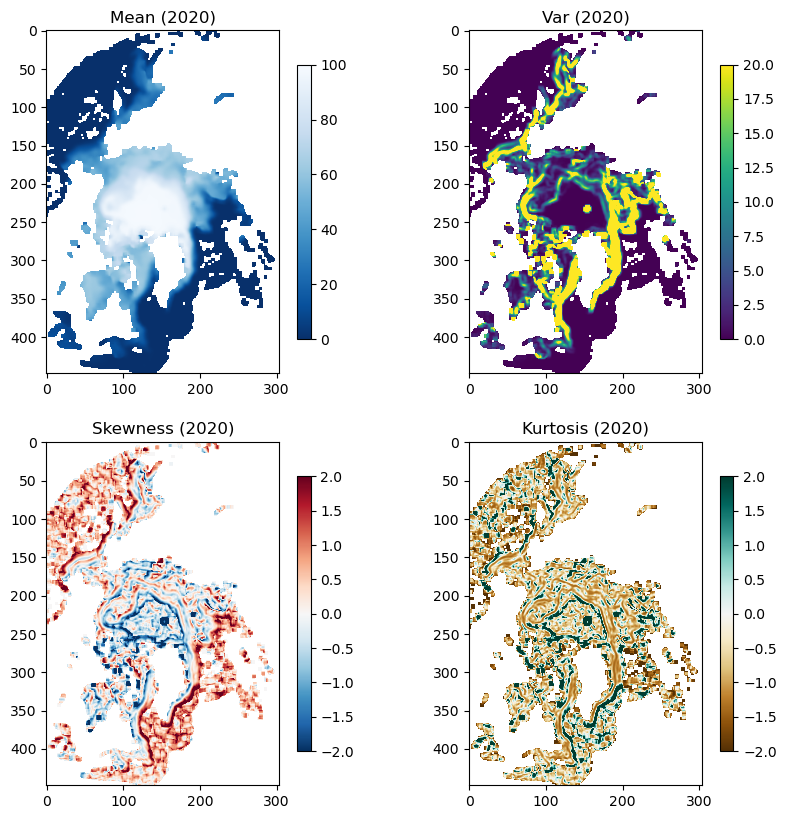

In [43]:
## Yearly skewness & kurtosis ---------------------------------
df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)

for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    idx = (df_sie['year'] == y)
    sic_mean = np.mean(sic_con[:, :, idx], axis = 2)

    t0_str = str(y)
    
    r = 3 # smoothing factor (window size)
    z_mean, z_var, z_skew, z_kurt = get_statistics(sic_mean, r) # calculate statistical moments
    
    fig, ax = plt.subplots(2,2,figsize = (10, 10), dpi = 100)
    ax_mean = ax[0][0]
    ax_var = ax[0][1]
    ax_skew = ax[1][0]
    ax_kurt = ax[1][1]
    
    # Draw mean image
    img_mean = ax_mean.imshow(z_mean, cmap = 'Blues_r', vmin = 0, vmax = 100)
    fig.colorbar(img_mean, ax = ax_mean, shrink = 0.8, pad = 0.05)
    ax_mean.set_title("Mean ({0})".format(t0_str))
    
    # Draw variance image
    img_var = ax_var.imshow(z_var, vmin = 0, vmax = 20)
    fig.colorbar(img_var, ax = ax_var, shrink = 0.8, pad = 0.05)
    ax_var.set_title("Var ({0})".format(t0_str))
    
    # Draw skewness image
    img_skew = ax_skew.imshow(z_skew, cmap = "RdBu_r", vmin = -2, vmax = 2)
    fig.colorbar(img_skew, ax = ax_skew, shrink = 0.8, pad = 0.05)
    ax_skew.set_title("Skewness ({0})".format(t0_str))
    
    # Draw kurtosis image
    img_kurt = ax_kurt.imshow(z_kurt, cmap = "BrBG", vmin = -2, vmax = 2)
    fig.colorbar(img_kurt, ax = ax_kurt, shrink = 0.8, pad = 0.05)
    ax_kurt.set_title("Kurtosis ({0})".format(t0_str))
    
    plt.savefig("result\\3_stat_moments\\stat_moments_r{0}_{1}.png".format(r, t0_str),
                bbox_inches = "tight")
#     plt.close()
    
    print(t0_str)

In [37]:
## Monthly skewness & kurtosis ---------------------------------
for y in range(2013, 2014): #df_sie['year'].unique()[:]:
    for m in sorted(df_sie['month'].unique()[:]):
        idx = (df_sie['year'] == y) & (df_sie['month'] == m)
        sic_mean = np.mean(sic_con[:, :, idx], axis = 2)
        sic_mean[sic_mean == 0] = np.nan
        t0_str = str(y) + str(m).zfill(2)
        
        r = 3 # smoothing factor (window size)
        z_mean, z_var, z_skew, z_kurt = get_statistics(sic_mean, r)

        fig, ax = plt.subplots(2,2,figsize = (10, 10), dpi = 100)
        ax_mean = ax[0][0]
        ax_var = ax[0][1]
        ax_skew = ax[1][0]
        ax_kurt = ax[1][1]
        
        # Draw mean image
        img_mean = ax_mean.imshow(z_mean, cmap = 'Blues_r', vmin = 0, vmax = 100)
        fig.colorbar(img_mean, ax = ax_mean, shrink = 0.8, pad = 0.05)
        ax_mean.set_title("Mean ({0})".format(t0_str))
        
        # Draw variance image
        img_var = ax_var.imshow(z_var, vmin = 0, vmax = 20)
        fig.colorbar(img_var, ax = ax_var, shrink = 0.8, pad = 0.05)
        ax_var.set_title("Var ({0})".format(t0_str))
        
        # Draw skewness image
        img_skew = ax_skew.imshow(z_skew, cmap = "RdBu_r", vmin = -2, vmax = 2)
        fig.colorbar(img_skew, ax = ax_skew, shrink = 0.8, pad = 0.05)
        ax_skew.set_title("Skewness ({0})".format(t0_str))
        
        # Draw kurtosis image
        img_kurt = ax_kurt.imshow(z_kurt, cmap = "BrBG", vmin = -2, vmax = 2)
        fig.colorbar(img_kurt, ax = ax_kurt, shrink = 0.8, pad = 0.05)
        ax_kurt.set_title("Kurtosis ({0})".format(t0_str))

        plt.savefig("result\\3_stat_moments\\stat_moments_r{0}_{1}.png".format(r, t0_str),
                    bbox_inches = "tight")
        
        plt.close()
        print(t0_str)

201308
201309


## (5) PCA

In [39]:
from sklearn.decomposition import PCA

In [40]:
## Prepare functions for PCA analysis
def reshape_pca(sic_con):
    # Reshape 3D sic_con array into 2D array for PCA analysis
    h, w, s = np.shape(sic_con)
    pca_in = np.zeros((h*w, s))
    for i in range(0, h):
        for j in range(0, w):
            pca_in[i + j*h, :] = sic_con[i, j, :]
    return pca_in

def decomposition_pca(p, n, lat):
    # p: pca components
    # n: number of PCA components
    # Reshape 2D PCA components into 3D arrays (original grids)
    h, w = np.shape(lat)
    out = np.zeros((h, w, n))
    
    for i in range(0, h):
        for j in range(0, w):
            out[i, j, :] = p[i + j*h, :n]
            
    return out

def draw_pca(pca_c, imgname):
    # Plot first 6 PCA components at 6 panels
    fig, ax = plt.subplots(2,3,figsize = (14, 10), dpi = 80)
    h, w = np.shape(ax)
    
    n = 0
    for i in range(0, h):
        for j in range(0, w):
            plt.subplot2grid((h, w), (i,j))
            plt.imshow(pca_c[:, :, n])  
            plt.colorbar(shrink = 0.8)
            plt.title("PCA_{0}".format(n+1))
            n+=1
            
    plt.savefig(imgname, bbox_inches = "tight")

2013
2014
2015
2016
2017
2018
2019
2020


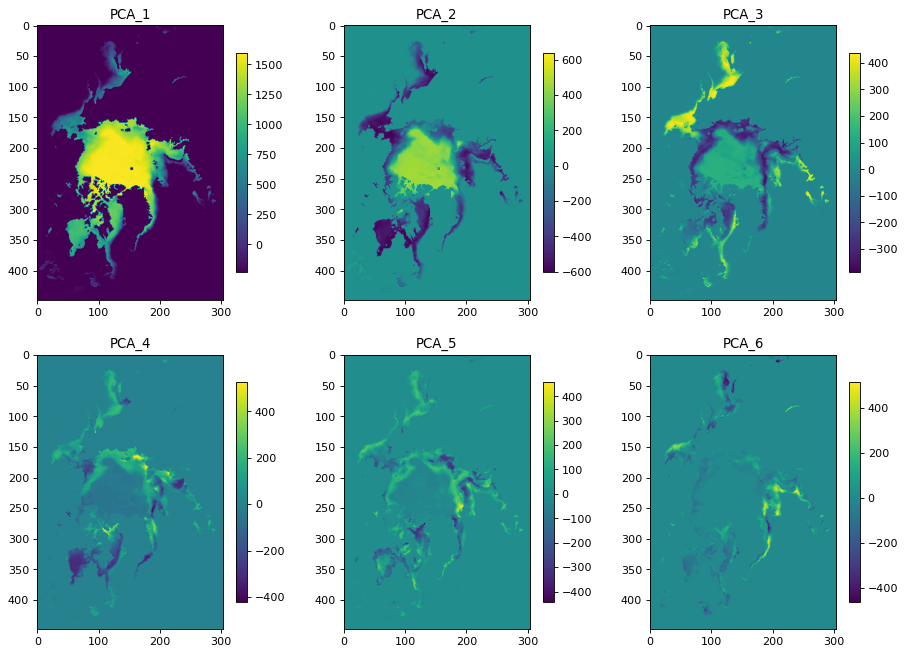

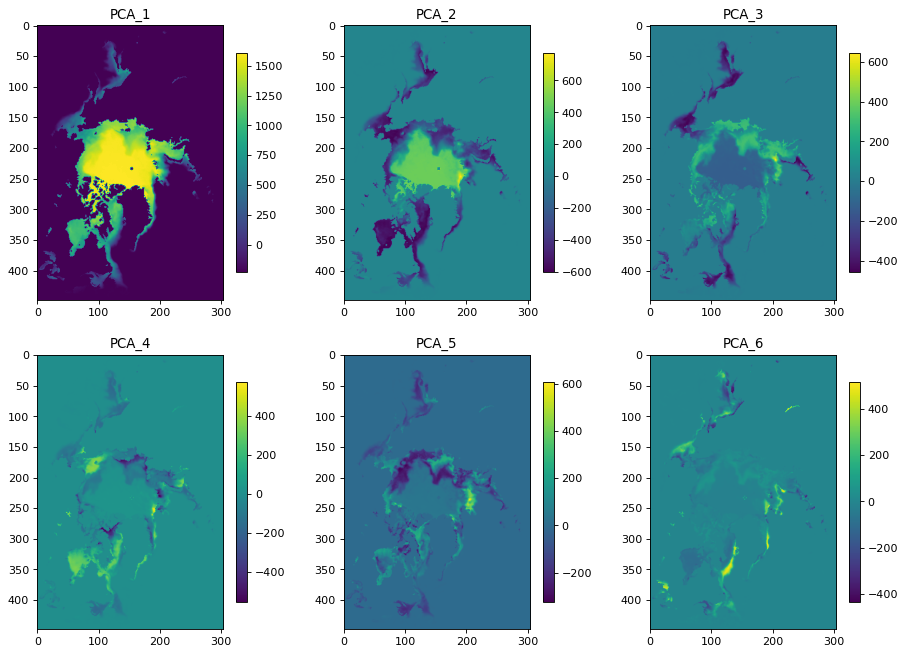

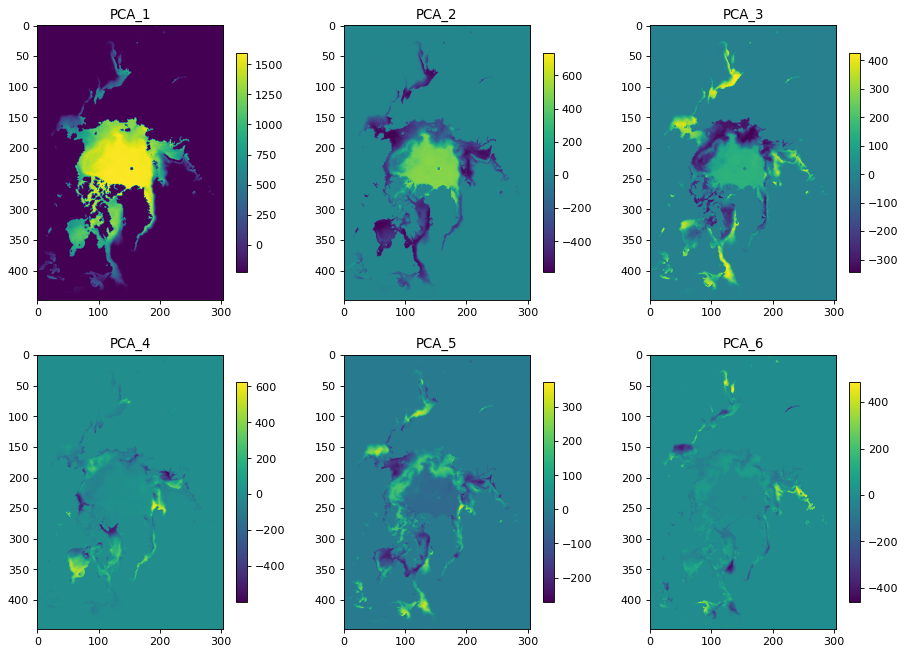

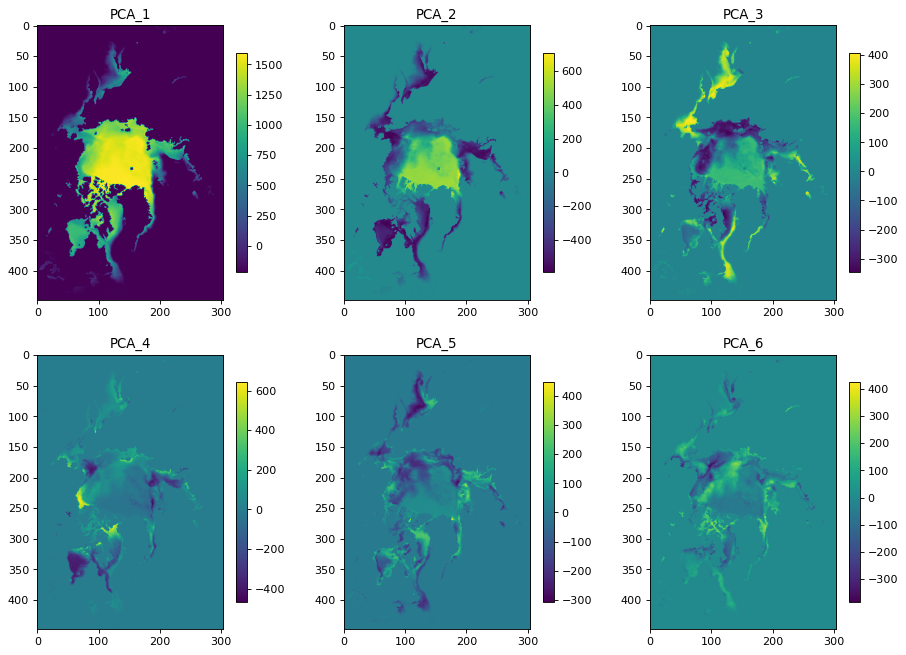

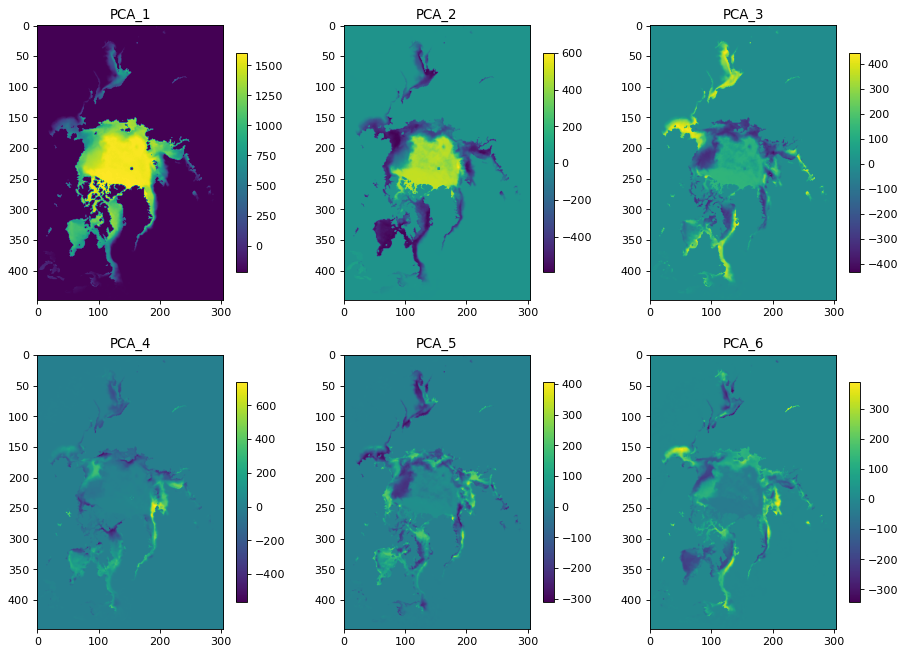

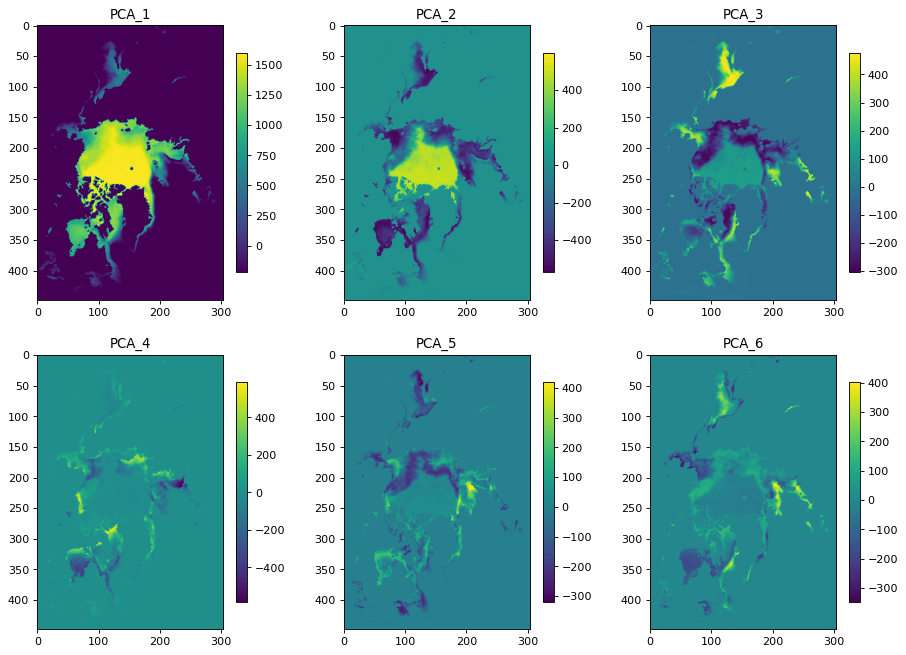

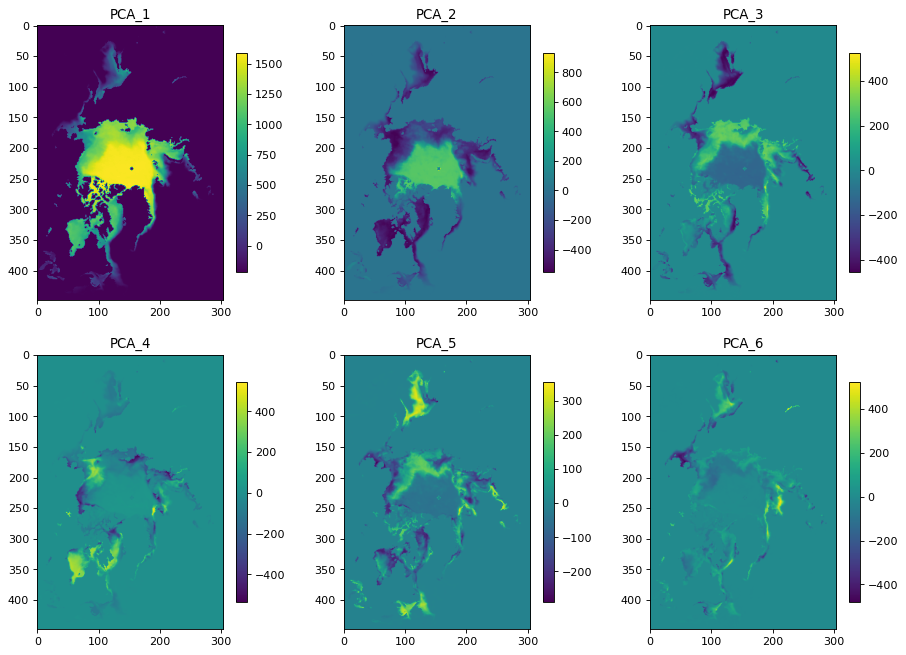

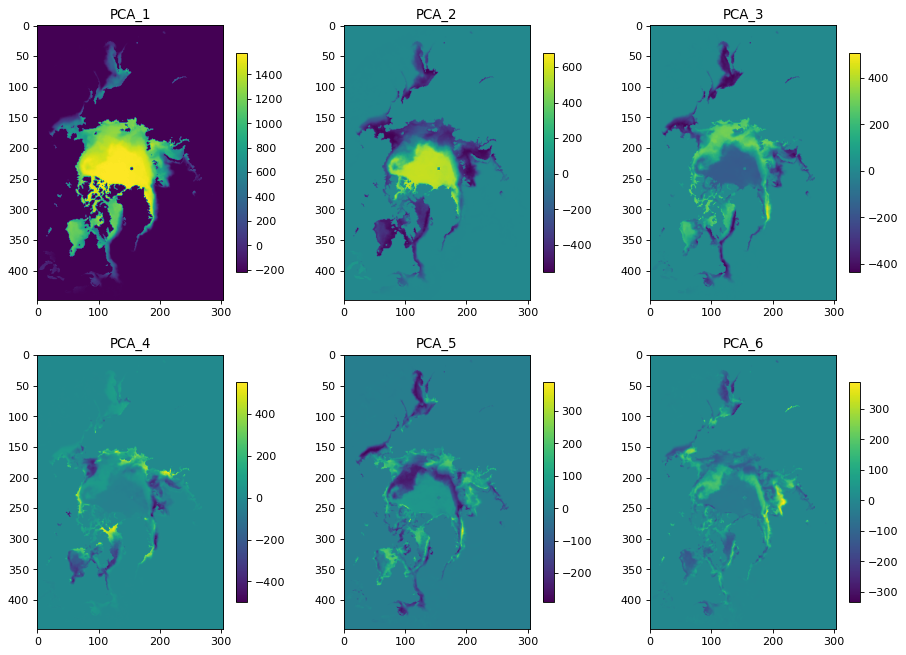

In [42]:
df_sie = pd.read_csv("result\\SIE_NH.csv", index_col = 0)

# PCA analysis by year ----------------------------------------
for y in range(2013, 2021): #df_sie['year'].unique()[:]:
    idx = (df_sie['year'] == y)
    sic_part = sic_con[:, :, idx]
    
    # PCA analysis
    n = 10
    pca_in = reshape_pca(sic_part) # make input for PCA
    pca = PCA(n_components=n)
    pca_c0 = pca.fit_transform(pca_in) # PCA tranformation
    pca_c = decomposition_pca(pca_c0, n, lat) # convert 2D array into original 3D array again
    del pca_c0, pca_in
    
    imgname = "result\\4_PCA\\PCA_{0}.png".format(y)
    draw_pca(pca_c, imgname)
    
    print(y)

## The END